In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../_data/Kr2010.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'Right']])
X_train = np.asarray(tr_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'Right']])
X_test = np.asarray(ts_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2448, 4) (1074, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
#     ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    ndt = tf.convert_to_tensor([min_rt[i]/(1+ tf.math.log(1 + tf.exp(model.layers[-1].weights[-1][i-1]))) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, obs_train, shuffle=False, batch_size=X_train.shape[0], epochs=4000)

Epoch 1/4000
1/1 [==============================] - 73s 73s/step - loss: 14187.2383
Epoch 2/4000
1/1 [==============================] - 0s 27ms/step - loss: 14124.2021
Epoch 3/4000
1/1 [==============================] - 0s 19ms/step - loss: 14080.3232
Epoch 4/4000
1/1 [==============================] - 0s 18ms/step - loss: 14044.5176
Epoch 5/4000
1/1 [==============================] - 0s 18ms/step - loss: 14013.2861
Epoch 6/4000
1/1 [==============================] - 0s 18ms/step - loss: 13984.9980
Epoch 7/4000
1/1 [==============================] - 0s 18ms/step - loss: 13958.7568
Epoch 8/4000
1/1 [==============================] - 0s 18ms/step - loss: 13934.0176
Epoch 9/4000
1/1 [==============================] - 0s 18ms/step - loss: 13910.4277
Epoch 10/4000
1/1 [==============================] - 0s 18ms/step - loss: 13887.7334
Epoch 11/4000
1/1 [==============================] - 0s 19ms/step - loss: 13865.7578
Epoch 12/4000
1/1 [==============================] - 0s 18ms/step - loss: 

1/1 [==============================] - 0s 28ms/step - loss: 11539.4502
Epoch 193/4000
1/1 [==============================] - 0s 28ms/step - loss: 11531.1621
Epoch 194/4000
1/1 [==============================] - 0s 28ms/step - loss: 11522.8936
Epoch 195/4000
1/1 [==============================] - 0s 28ms/step - loss: 11514.6445
Epoch 196/4000
1/1 [==============================] - 0s 28ms/step - loss: 11506.4180
Epoch 197/4000
1/1 [==============================] - 0s 28ms/step - loss: 11498.2090
Epoch 198/4000
1/1 [==============================] - 0s 28ms/step - loss: 11490.0215
Epoch 199/4000
1/1 [==============================] - 0s 28ms/step - loss: 11481.8574
Epoch 200/4000
1/1 [==============================] - 0s 28ms/step - loss: 11473.7139
Epoch 201/4000
1/1 [==============================] - 0s 28ms/step - loss: 11465.5918
Epoch 202/4000
1/1 [==============================] - 0s 27ms/step - loss: 11457.4902
Epoch 203/4000
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 10126.1992
Epoch 383/4000
1/1 [==============================] - 0s 28ms/step - loss: 10119.1230
Epoch 384/4000
1/1 [==============================] - 0s 28ms/step - loss: 10112.0615
Epoch 385/4000
1/1 [==============================] - 0s 28ms/step - loss: 10105.0117
Epoch 386/4000
1/1 [==============================] - 0s 28ms/step - loss: 10097.9775
Epoch 387/4000
1/1 [==============================] - 0s 28ms/step - loss: 10090.9551
Epoch 388/4000
1/1 [==============================] - 0s 28ms/step - loss: 10083.9482
Epoch 389/4000
1/1 [==============================] - 0s 28ms/step - loss: 10076.9531
Epoch 390/4000
1/1 [==============================] - 0s 28ms/step - loss: 10069.9756
Epoch 391/4000
1/1 [==============================] - 0s 28ms/step - loss: 10063.0098
Epoch 392/4000
1/1 [==============================] - 0s 28ms/step - loss: 10056.0615
Epoch 393/4000
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 8983.6387
Epoch 575/4000
1/1 [==============================] - 0s 28ms/step - loss: 8978.5566
Epoch 576/4000
1/1 [==============================] - 0s 28ms/step - loss: 8973.4824
Epoch 577/4000
1/1 [==============================] - 0s 28ms/step - loss: 8968.4160
Epoch 578/4000
1/1 [==============================] - 0s 28ms/step - loss: 8963.3584
Epoch 579/4000
1/1 [==============================] - 0s 28ms/step - loss: 8958.3076
Epoch 580/4000
1/1 [==============================] - 0s 28ms/step - loss: 8953.2666
Epoch 581/4000
1/1 [==============================] - 0s 28ms/step - loss: 8948.2314
Epoch 582/4000
1/1 [==============================] - 0s 28ms/step - loss: 8943.2051
Epoch 583/4000
1/1 [==============================] - 0s 28ms/step - loss: 8938.1855
Epoch 584/4000
1/1 [==============================] - 0s 28ms/step - loss: 8933.1758
Epoch 585/4000
1/1 [==============================] - 0s 28ms/step - loss: 8928.

1/1 [==============================] - 0s 28ms/step - loss: 8143.6362
Epoch 767/4000
1/1 [==============================] - 0s 28ms/step - loss: 8139.9263
Epoch 768/4000
1/1 [==============================] - 0s 27ms/step - loss: 8136.1860
Epoch 769/4000
1/1 [==============================] - 0s 28ms/step - loss: 8132.4888
Epoch 770/4000
1/1 [==============================] - 0s 28ms/step - loss: 8128.7607
Epoch 771/4000
1/1 [==============================] - 0s 28ms/step - loss: 8125.0742
Epoch 772/4000
1/1 [==============================] - 0s 28ms/step - loss: 8121.3569
Epoch 773/4000
1/1 [==============================] - 0s 28ms/step - loss: 8117.6836
Epoch 774/4000
1/1 [==============================] - 0s 28ms/step - loss: 8113.9780
Epoch 775/4000
1/1 [==============================] - 0s 28ms/step - loss: 8110.3154
Epoch 776/4000
1/1 [==============================] - 0s 28ms/step - loss: 8106.6216
Epoch 777/4000
1/1 [==============================] - 0s 28ms/step - loss: 8102.

1/1 [==============================] - 0s 29ms/step - loss: 7530.0786
Epoch 959/4000
1/1 [==============================] - 0s 29ms/step - loss: 7527.4238
Epoch 960/4000
1/1 [==============================] - 0s 30ms/step - loss: 7524.7490
Epoch 961/4000
1/1 [==============================] - 0s 30ms/step - loss: 7522.1064
Epoch 962/4000
1/1 [==============================] - 0s 30ms/step - loss: 7519.4419
Epoch 963/4000
1/1 [==============================] - 0s 29ms/step - loss: 7516.8110
Epoch 964/4000
1/1 [==============================] - 0s 29ms/step - loss: 7514.1592
Epoch 965/4000
1/1 [==============================] - 0s 29ms/step - loss: 7511.5391
Epoch 966/4000
1/1 [==============================] - 0s 29ms/step - loss: 7508.8994
Epoch 967/4000
1/1 [==============================] - 0s 29ms/step - loss: 7506.2891
Epoch 968/4000
1/1 [==============================] - 0s 29ms/step - loss: 7503.6592
Epoch 969/4000
1/1 [==============================] - 0s 29ms/step - loss: 7501.

1/1 [==============================] - 0s 28ms/step - loss: 7122.9683
Epoch 1149/4000
1/1 [==============================] - 0s 28ms/step - loss: 7121.3267
Epoch 1150/4000
1/1 [==============================] - 0s 28ms/step - loss: 7119.6953
Epoch 1151/4000
1/1 [==============================] - 0s 28ms/step - loss: 7118.0640
Epoch 1152/4000
1/1 [==============================] - 0s 28ms/step - loss: 7116.4414
Epoch 1153/4000
1/1 [==============================] - 0s 28ms/step - loss: 7114.8213
Epoch 1154/4000
1/1 [==============================] - 0s 28ms/step - loss: 7113.2100
Epoch 1155/4000
1/1 [==============================] - 0s 28ms/step - loss: 7111.5947
Epoch 1156/4000
1/1 [==============================] - 0s 28ms/step - loss: 7109.9937
Epoch 1157/4000
1/1 [==============================] - 0s 28ms/step - loss: 7108.3896
Epoch 1158/4000
1/1 [==============================] - 0s 28ms/step - loss: 7106.7974
Epoch 1159/4000
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 36ms/step - loss: 6886.8667
Epoch 1339/4000
1/1 [==============================] - 0s 32ms/step - loss: 6885.9541
Epoch 1340/4000
1/1 [==============================] - 0s 31ms/step - loss: 6885.0449
Epoch 1341/4000
1/1 [==============================] - 0s 31ms/step - loss: 6884.1504
Epoch 1342/4000
1/1 [==============================] - 0s 32ms/step - loss: 6883.2368
Epoch 1343/4000
1/1 [==============================] - 0s 31ms/step - loss: 6882.3535
Epoch 1344/4000
1/1 [==============================] - 0s 31ms/step - loss: 6881.4282
Epoch 1345/4000
1/1 [==============================] - 0s 30ms/step - loss: 6880.5415
Epoch 1346/4000
1/1 [==============================] - 0s 30ms/step - loss: 6879.6357
Epoch 1347/4000
1/1 [==============================] - 0s 30ms/step - loss: 6878.7583
Epoch 1348/4000
1/1 [==============================] - 0s 30ms/step - loss: 6877.8579
Epoch 1349/4000
1/1 [==============================] - 0s 30ms/step - 

1/1 [==============================] - 0s 30ms/step - loss: 6754.3550
Epoch 1529/4000
1/1 [==============================] - 0s 30ms/step - loss: 6753.9297
Epoch 1530/4000
1/1 [==============================] - 0s 30ms/step - loss: 6753.3691
Epoch 1531/4000
1/1 [==============================] - 0s 29ms/step - loss: 6752.8730
Epoch 1532/4000
1/1 [==============================] - 0s 29ms/step - loss: 6752.3213
Epoch 1533/4000
1/1 [==============================] - 0s 28ms/step - loss: 6751.8608
Epoch 1534/4000
1/1 [==============================] - 0s 29ms/step - loss: 6751.3140
Epoch 1535/4000
1/1 [==============================] - 0s 29ms/step - loss: 6750.8125
Epoch 1536/4000
1/1 [==============================] - 0s 29ms/step - loss: 6750.2139
Epoch 1537/4000
1/1 [==============================] - 0s 29ms/step - loss: 6749.6807
Epoch 1538/4000
1/1 [==============================] - 0s 29ms/step - loss: 6749.0610
Epoch 1539/4000
1/1 [==============================] - 0s 29ms/step - 

1/1 [==============================] - 0s 29ms/step - loss: 6669.7676
Epoch 1719/4000
1/1 [==============================] - 0s 29ms/step - loss: 6669.5659
Epoch 1720/4000
1/1 [==============================] - 0s 29ms/step - loss: 6669.7451
Epoch 1721/4000
1/1 [==============================] - 0s 29ms/step - loss: 6669.4873
Epoch 1722/4000
1/1 [==============================] - 0s 29ms/step - loss: 6668.8457
Epoch 1723/4000
1/1 [==============================] - 0s 30ms/step - loss: 6668.9531
Epoch 1724/4000
1/1 [==============================] - 0s 30ms/step - loss: 6667.6538
Epoch 1725/4000
1/1 [==============================] - 0s 30ms/step - loss: 6667.3379
Epoch 1726/4000
1/1 [==============================] - 0s 29ms/step - loss: 6666.6621
Epoch 1727/4000
1/1 [==============================] - 0s 30ms/step - loss: 6666.7041
Epoch 1728/4000
1/1 [==============================] - 0s 30ms/step - loss: 6665.9160
Epoch 1729/4000
1/1 [==============================] - 0s 29ms/step - 

1/1 [==============================] - 0s 34ms/step - loss: 6612.2285
Epoch 1909/4000
1/1 [==============================] - 0s 30ms/step - loss: 6612.0557
Epoch 1910/4000
1/1 [==============================] - 0s 30ms/step - loss: 6612.1060
Epoch 1911/4000
1/1 [==============================] - 0s 30ms/step - loss: 6611.8311
Epoch 1912/4000
1/1 [==============================] - 0s 29ms/step - loss: 6610.8286
Epoch 1913/4000
1/1 [==============================] - 0s 30ms/step - loss: 6610.8994
Epoch 1914/4000
1/1 [==============================] - 0s 30ms/step - loss: 6610.8389
Epoch 1915/4000
1/1 [==============================] - 0s 30ms/step - loss: 6609.5562
Epoch 1916/4000
1/1 [==============================] - 0s 30ms/step - loss: 6609.2656
Epoch 1917/4000
1/1 [==============================] - 0s 31ms/step - loss: 6608.5635
Epoch 1918/4000
1/1 [==============================] - 0s 30ms/step - loss: 6612.3384
Epoch 1919/4000
1/1 [==============================] - 0s 30ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 6571.3389
Epoch 2099/4000
1/1 [==============================] - 0s 33ms/step - loss: 6572.3237
Epoch 2100/4000
1/1 [==============================] - 0s 34ms/step - loss: 6571.7075
Epoch 2101/4000
1/1 [==============================] - 0s 34ms/step - loss: 6570.7178
Epoch 2102/4000
1/1 [==============================] - 0s 33ms/step - loss: 6570.1445
Epoch 2103/4000
1/1 [==============================] - 0s 33ms/step - loss: 6570.3267
Epoch 2104/4000
1/1 [==============================] - 0s 32ms/step - loss: 6570.7852
Epoch 2105/4000
1/1 [==============================] - 0s 31ms/step - loss: 6570.6157
Epoch 2106/4000
1/1 [==============================] - 0s 31ms/step - loss: 6572.0420
Epoch 2107/4000
1/1 [==============================] - 0s 30ms/step - loss: 6572.1558
Epoch 2108/4000
1/1 [==============================] - 0s 30ms/step - loss: 6572.0396
Epoch 2109/4000
1/1 [==============================] - 0s 30ms/step - 

1/1 [==============================] - 0s 37ms/step - loss: 6543.2949
Epoch 2289/4000
1/1 [==============================] - 0s 31ms/step - loss: 6543.6489
Epoch 2290/4000
1/1 [==============================] - 0s 31ms/step - loss: 6543.8262
Epoch 2291/4000
1/1 [==============================] - 0s 34ms/step - loss: 6543.9014
Epoch 2292/4000
1/1 [==============================] - 0s 36ms/step - loss: 6543.9438
Epoch 2293/4000
1/1 [==============================] - 0s 32ms/step - loss: 6542.5220
Epoch 2294/4000
1/1 [==============================] - 0s 30ms/step - loss: 6543.0879
Epoch 2295/4000
1/1 [==============================] - 0s 30ms/step - loss: 6542.5254
Epoch 2296/4000
1/1 [==============================] - 0s 29ms/step - loss: 6543.1289
Epoch 2297/4000
1/1 [==============================] - 0s 29ms/step - loss: 6541.8750
Epoch 2298/4000
1/1 [==============================] - 0s 30ms/step - loss: 6542.2861
Epoch 2299/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 29ms/step - loss: 6520.9912
Epoch 2479/4000
1/1 [==============================] - 0s 30ms/step - loss: 6521.3042
Epoch 2480/4000
1/1 [==============================] - 0s 29ms/step - loss: 6519.4468
Epoch 2481/4000
1/1 [==============================] - 0s 32ms/step - loss: 6521.9609
Epoch 2482/4000
1/1 [==============================] - 0s 30ms/step - loss: 6518.0869
Epoch 2483/4000
1/1 [==============================] - 0s 29ms/step - loss: 6519.2383
Epoch 2484/4000
1/1 [==============================] - 0s 30ms/step - loss: 6518.2983
Epoch 2485/4000
1/1 [==============================] - 0s 28ms/step - loss: 6518.9199
Epoch 2486/4000
1/1 [==============================] - 0s 29ms/step - loss: 6518.3271
Epoch 2487/4000
1/1 [==============================] - 0s 30ms/step - loss: 6518.2744
Epoch 2488/4000
1/1 [==============================] - 0s 29ms/step - loss: 6519.7725
Epoch 2489/4000
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 29ms/step - loss: 6497.3726
Epoch 2669/4000
1/1 [==============================] - 0s 29ms/step - loss: 6497.1953
Epoch 2670/4000
1/1 [==============================] - 0s 30ms/step - loss: 6499.9893
Epoch 2671/4000
1/1 [==============================] - 0s 28ms/step - loss: 6502.1729
Epoch 2672/4000
1/1 [==============================] - 0s 28ms/step - loss: 6503.9688
Epoch 2673/4000
1/1 [==============================] - 0s 28ms/step - loss: 6503.9985
Epoch 2674/4000
1/1 [==============================] - 0s 28ms/step - loss: 6503.3462
Epoch 2675/4000
1/1 [==============================] - 0s 28ms/step - loss: 6500.8857
Epoch 2676/4000
1/1 [==============================] - 0s 28ms/step - loss: 6500.5215
Epoch 2677/4000
1/1 [==============================] - 0s 28ms/step - loss: nan
Epoch 2678/4000
1/1 [==============================] - 0s 28ms/step - loss: 6501.3818
Epoch 2679/4000
1/1 [==============================] - 0s 28ms/step - loss: 

1/1 [==============================] - 0s 27ms/step - loss: 6484.6826
Epoch 2859/4000
1/1 [==============================] - 0s 28ms/step - loss: 6482.3564
Epoch 2860/4000
1/1 [==============================] - 0s 28ms/step - loss: 6480.0322
Epoch 2861/4000
1/1 [==============================] - 0s 28ms/step - loss: 6480.9614
Epoch 2862/4000
1/1 [==============================] - 0s 28ms/step - loss: 6480.4077
Epoch 2863/4000
1/1 [==============================] - 0s 28ms/step - loss: 6480.1816
Epoch 2864/4000
1/1 [==============================] - 0s 28ms/step - loss: 6479.7480
Epoch 2865/4000
1/1 [==============================] - 0s 28ms/step - loss: 6480.8521
Epoch 2866/4000
1/1 [==============================] - 0s 30ms/step - loss: 6479.9512
Epoch 2867/4000
1/1 [==============================] - 0s 28ms/step - loss: 6480.9326
Epoch 2868/4000
1/1 [==============================] - 0s 28ms/step - loss: 6479.1924
Epoch 2869/4000
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 6463.1348
Epoch 3049/4000
1/1 [==============================] - 0s 28ms/step - loss: 6463.3574
Epoch 3050/4000
1/1 [==============================] - 0s 28ms/step - loss: 6462.8867
Epoch 3051/4000
1/1 [==============================] - 0s 28ms/step - loss: 6462.0254
Epoch 3052/4000
1/1 [==============================] - 0s 28ms/step - loss: 6462.1880
Epoch 3053/4000
1/1 [==============================] - 0s 28ms/step - loss: 6462.2993
Epoch 3054/4000
1/1 [==============================] - 0s 28ms/step - loss: 6462.5835
Epoch 3055/4000
1/1 [==============================] - 0s 28ms/step - loss: 6462.8076
Epoch 3056/4000
1/1 [==============================] - 0s 28ms/step - loss: 6462.5957
Epoch 3057/4000
1/1 [==============================] - 0s 28ms/step - loss: 6463.7524
Epoch 3058/4000
1/1 [==============================] - 0s 29ms/step - loss: 6463.6689
Epoch 3059/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 6446.4263
Epoch 3239/4000
1/1 [==============================] - 0s 28ms/step - loss: 6445.3774
Epoch 3240/4000
1/1 [==============================] - 0s 28ms/step - loss: 6446.6128
Epoch 3241/4000
1/1 [==============================] - 0s 29ms/step - loss: 6445.6230
Epoch 3242/4000
1/1 [==============================] - 0s 29ms/step - loss: 6445.3682
Epoch 3243/4000
1/1 [==============================] - 0s 29ms/step - loss: 6444.7925
Epoch 3244/4000
1/1 [==============================] - 0s 30ms/step - loss: 6443.9404
Epoch 3245/4000
1/1 [==============================] - 0s 32ms/step - loss: 6444.7144
Epoch 3246/4000
1/1 [==============================] - 0s 33ms/step - loss: 6444.2749
Epoch 3247/4000
1/1 [==============================] - 0s 33ms/step - loss: 6445.1309
Epoch 3248/4000
1/1 [==============================] - 0s 30ms/step - loss: 6445.8633
Epoch 3249/4000
1/1 [==============================] - 0s 29ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 6429.9590
Epoch 3429/4000
1/1 [==============================] - 0s 28ms/step - loss: 6429.4424
Epoch 3430/4000
1/1 [==============================] - 0s 28ms/step - loss: 6429.2334
Epoch 3431/4000
1/1 [==============================] - 0s 28ms/step - loss: 6427.4600
Epoch 3432/4000
1/1 [==============================] - 0s 28ms/step - loss: 6427.8945
Epoch 3433/4000
1/1 [==============================] - 0s 28ms/step - loss: 6428.1416
Epoch 3434/4000
1/1 [==============================] - 0s 28ms/step - loss: 6428.2583
Epoch 3435/4000
1/1 [==============================] - 0s 28ms/step - loss: 6429.5703
Epoch 3436/4000
1/1 [==============================] - 0s 27ms/step - loss: 6429.4712
Epoch 3437/4000
1/1 [==============================] - 0s 28ms/step - loss: 6429.8638
Epoch 3438/4000
1/1 [==============================] - 0s 28ms/step - loss: 6429.2471
Epoch 3439/4000
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 29ms/step - loss: 6413.9438
Epoch 3619/4000
1/1 [==============================] - 0s 30ms/step - loss: 6413.1152
Epoch 3620/4000
1/1 [==============================] - 0s 29ms/step - loss: 6413.1416
Epoch 3621/4000
1/1 [==============================] - 0s 28ms/step - loss: 6414.4238
Epoch 3622/4000
1/1 [==============================] - 0s 29ms/step - loss: 6413.5386
Epoch 3623/4000
1/1 [==============================] - 0s 28ms/step - loss: 6414.7217
Epoch 3624/4000
1/1 [==============================] - 0s 28ms/step - loss: 6414.7935
Epoch 3625/4000
1/1 [==============================] - 0s 29ms/step - loss: 6413.5039
Epoch 3626/4000
1/1 [==============================] - 0s 31ms/step - loss: 6414.3652
Epoch 3627/4000
1/1 [==============================] - 0s 33ms/step - loss: 6415.0439
Epoch 3628/4000
1/1 [==============================] - 0s 34ms/step - loss: 6414.1006
Epoch 3629/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 29ms/step - loss: 6400.7427
Epoch 3809/4000
1/1 [==============================] - 0s 28ms/step - loss: 6401.9023
Epoch 3810/4000
1/1 [==============================] - 0s 28ms/step - loss: 6401.4180
Epoch 3811/4000
1/1 [==============================] - 0s 28ms/step - loss: 6401.0352
Epoch 3812/4000
1/1 [==============================] - 0s 28ms/step - loss: 6401.3857
Epoch 3813/4000
1/1 [==============================] - 0s 28ms/step - loss: 6401.5527
Epoch 3814/4000
1/1 [==============================] - 0s 28ms/step - loss: 6400.5371
Epoch 3815/4000
1/1 [==============================] - 0s 30ms/step - loss: 6401.7202
Epoch 3816/4000
1/1 [==============================] - 0s 30ms/step - loss: 6401.1177
Epoch 3817/4000
1/1 [==============================] - 0s 31ms/step - loss: 6399.1475
Epoch 3818/4000
1/1 [==============================] - 0s 31ms/step - loss: 6400.4570
Epoch 3819/4000
1/1 [==============================] - 0s 29ms/step - 

1/1 [==============================] - 0s 28ms/step - loss: 6390.0293
Epoch 3999/4000
1/1 [==============================] - 0s 28ms/step - loss: 6389.0361
Epoch 4000/4000
1/1 [==============================] - 0s 28ms/step - loss: 6389.5586


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

34/34 [==============================] - 0s 302us/step


In [44]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['val1'].append(ts_df.item_value_1[s])
        pred_bhv['val2'].append(ts_df.item_value_2[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
#         if ts_df['item_value_1'][s] > ts_df['item_value_2'][s] and ch == 0:
#             pred_bhv['ch'].append(1)
#         elif ts_df['item_value_2'][s] > ts_df['item_value_1'][s] and ch == 1:
#             pred_bhv['ch'].append(1)
#         elif ts_df['item_value_2'][s] == ts_df['item_value_1'][s]:
#             pred_bhv['ch'].append(1)
#         else:
#             pred_bhv['ch'].append(0)
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
# high = ((ts_df['item_value_2'] >= ts_df['item_value_1']).map({True:2, 
#                                                               False:1}) == ts_df['choice']).map({True:1, 
#                                                                                                  False:0})
# high[ts_df['item_value_2'] == ts_df['item_value_1']] = 1
# ts_df['is_high'] = high 

In [41]:
ts_df

,sbj,Trial,rt,item_value_1,item_value_2,choice,DwellLeft,DwellRight,OV,rt_max,Right,gaze_1,gaze_2,diff,Overall Value,Right Value - Left Value,gaze diff,Dwell Time Advantage (R - L),Magnitude
0,1,3.0,1.121,5.0,10.0,2.0,540.0,262.0,15.0,3.794033,1,0.673317,0.326683,5.0,15.0,5.0,2.0,-0.50,High
1,1,81.0,1.167,2.0,6.0,2.0,298.0,579.0,8.0,3.794033,1,0.339795,0.660205,4.0,8.0,4.0,5.0,0.25,High
2,1,25.0,3.439,4.0,3.0,1.0,1539.0,1612.0,7.0,3.794033,0,0.488416,0.511584,1.0,7.0,-1.0,4.0,0.00,Low
3,1,11.0,1.426,6.0,5.0,1.0,1057.0,0.0,11.0,3.794033,0,1.000000,0.000000,1.0,11.0,-1.0,0.0,-1.00,High
4,1,38.0,1.304,3.0,2.0,2.0,216.0,640.0,5.0,3.794033,1,0.252336,0.747664,1.0,5.0,-1.0,6.0,0.50,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,39,21.0,2.721,2.0,0.0,1.0,817.0,739.0,2.0,5.164726,0,0.525064,0.474936,2.0,2.0,-2.0,4.0,0.00,Low
1070,39,30.0,1.469,0.0,1.0,1.0,240.0,954.0,1.0,5.164726,0,0.201005,0.798995,1.0,1.0,1.0,7.0,0.75,Low
1071,39,27.0,1.210,1.0,1.0,1.0,298.0,595.0,2.0,5.164726,0,0.333707,0.666293,0.0,2.0,0.0,5.0,0.25,Low
1072,39,60.0,2.027,3.0,4.0,1.0,1232.0,517.0,7.0,5.164726,0,0.704403,0.295597,1.0,7.0,1.0,2.0,-0.50,Low


In [46]:
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

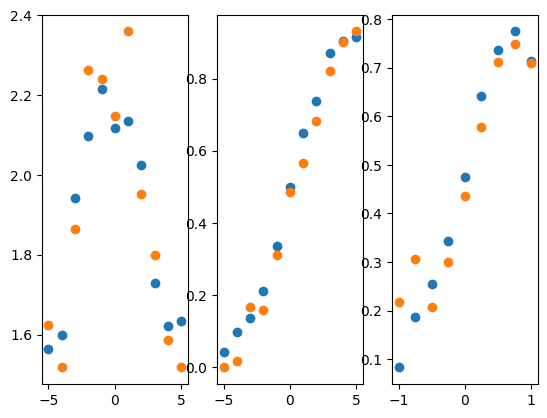

In [48]:
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1);

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1);

PearsonRResult(statistic=0.926962676035462, pvalue=2.4647479319680983e-17)
0.7522805356468341
0.14043126427189362
PearsonRResult(statistic=0.28323952688335663, pvalue=0.08059216157575262)
-0.19893802029904695
0.012396471200420967


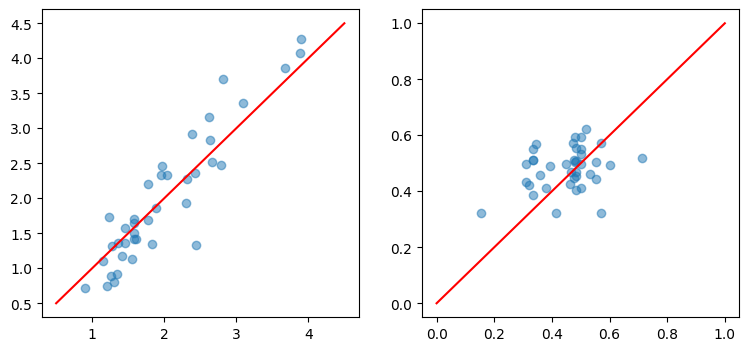

In [26]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
pearsonr
print(pearsonr(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv.groupby(by='sbj')['rt'].mean()))
print(r2_score(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv.groupby(by='sbj')['rt'].mean()))
print(mean_squared_error(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv.groupby(by='sbj')['rt'].mean()))

plt.plot(np.linspace(0.5, 4.5, 100), np.linspace(0.5, 4.5, 100), c='red')
plt.scatter(ts_df.groupby(by='sbj')['rt'].mean(),
            pred_bhv.groupby(by='sbj')['rt'].mean(), alpha=0.5);

plt.subplot(122)
print(pearsonr(ts_df.groupby(by='sbj')['Right'].mean(),
               pred_bhv.groupby(by='sbj')['ch'].mean()))
print(r2_score(ts_df.groupby(by='sbj')['Right'].mean(),
               pred_bhv.groupby(by='sbj')['ch'].mean()))
print(mean_squared_error(ts_df.groupby(by='sbj')['Right'].mean(),
               pred_bhv.groupby(by='sbj')['ch'].mean()))

plt.plot(np.linspace(0., 1, 100), np.linspace(0., 1, 100), c='red')
plt.scatter(ts_df.groupby(by='sbj')['Right'].mean(),
            pred_bhv.groupby(by='sbj')['ch'].mean(), alpha=0.5);

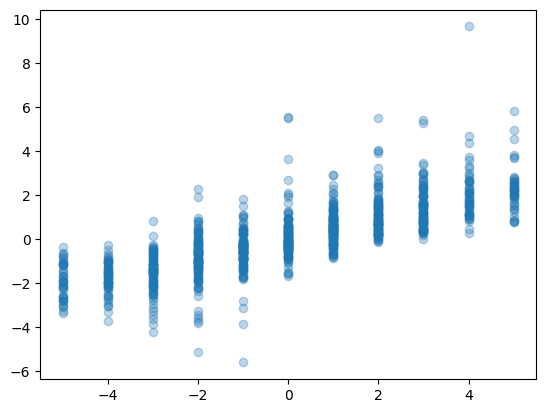

In [14]:
plt.scatter(X_test[:, 0] - X_test[:, 1], scaling*pred_v[:, 0] - scaling*pred_v[:, 1], alpha=0.3);

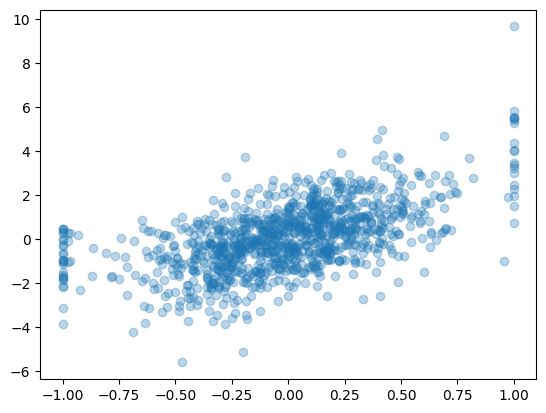

In [15]:
plt.scatter(X_test[:, 2] - X_test[:, 3], scaling*pred_v[:, 0] - scaling*pred_v[:, 1], alpha=0.3);

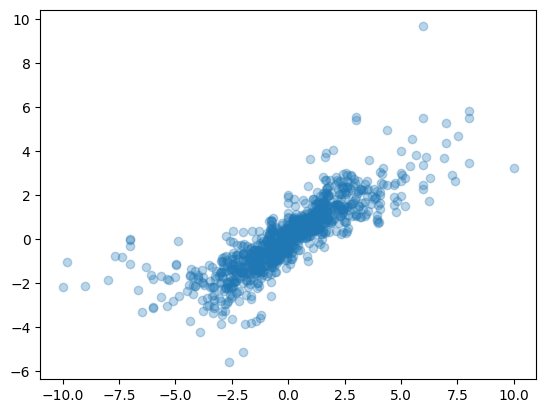

In [16]:
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            scaling*pred_v[:, 0] - scaling*pred_v[:, 1], alpha=0.3);

In [18]:
pred_v_train = model.predict(X_train)
scaling_tr = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling_tr = np.asanyarray([scaling_tr[i-1] for i in tr_df['sbj']])

77/77 [==============================] - 0s 300us/step


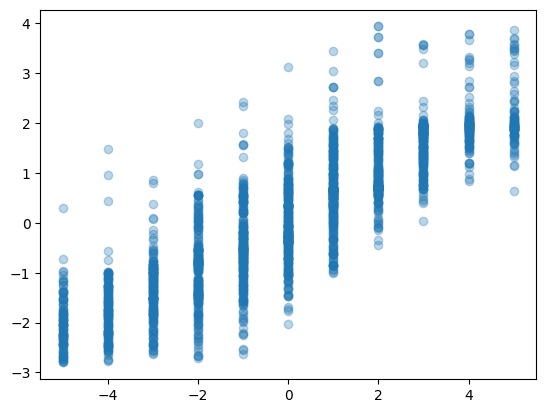

In [19]:
plt.scatter(X_train[:, 0] - X_train[:, 1], 
            pred_v_train[:, 0] - pred_v_train[:, 1], alpha=0.3);

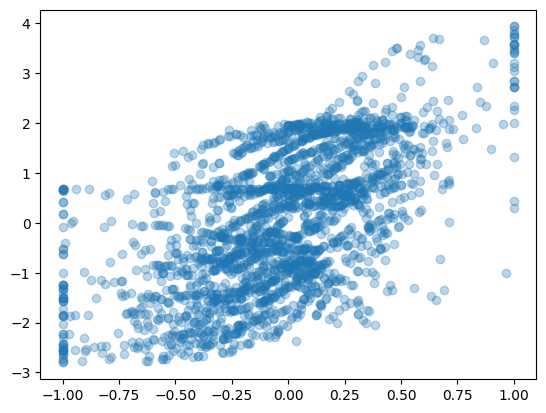

In [20]:
plt.scatter(X_train[:, 2] - X_train[:, 3], 
            pred_v_train[:, 0] - pred_v_train[:, 1], alpha=0.3);

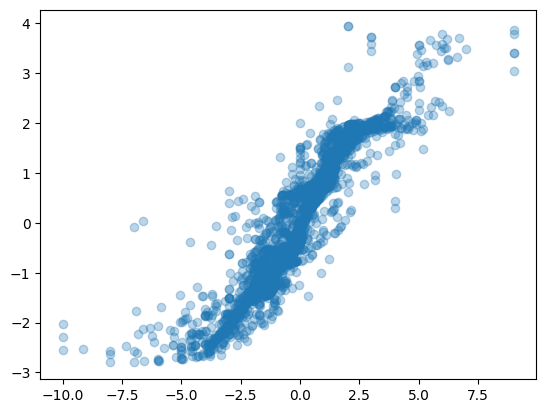

In [21]:
plt.scatter(X_train[:, 0]*X_train[:, 2] - X_train[:, 1]*X_train[:, 3], 
            pred_v_train[:, 0] - pred_v_train[:, 1], alpha=0.3);

In [24]:
ts_df

,sbj,Trial,rt,item_value_1,item_value_2,choice,DwellLeft,DwellRight,OV,rt_max,Right,gaze_1,gaze_2,diff,Overall Value,Right Value - Left Value,gaze diff,Dwell Time Advantage (R - L),Magnitude
0,1,3.0,1.121,5.0,10.0,2.0,540.0,262.0,15.0,3.794033,1,0.673317,0.326683,5.0,15.0,5.0,2.0,-0.50,High
1,1,81.0,1.167,2.0,6.0,2.0,298.0,579.0,8.0,3.794033,1,0.339795,0.660205,4.0,8.0,4.0,5.0,0.25,High
2,1,25.0,3.439,4.0,3.0,1.0,1539.0,1612.0,7.0,3.794033,0,0.488416,0.511584,1.0,7.0,-1.0,4.0,0.00,Low
3,1,11.0,1.426,6.0,5.0,1.0,1057.0,0.0,11.0,3.794033,0,1.000000,0.000000,1.0,11.0,-1.0,0.0,-1.00,High
4,1,38.0,1.304,3.0,2.0,2.0,216.0,640.0,5.0,3.794033,1,0.252336,0.747664,1.0,5.0,-1.0,6.0,0.50,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,39,21.0,2.721,2.0,0.0,1.0,817.0,739.0,2.0,5.164726,0,0.525064,0.474936,2.0,2.0,-2.0,4.0,0.00,Low
1070,39,30.0,1.469,0.0,1.0,1.0,240.0,954.0,1.0,5.164726,0,0.201005,0.798995,1.0,1.0,1.0,7.0,0.75,Low
1071,39,27.0,1.210,1.0,1.0,1.0,298.0,595.0,2.0,5.164726,0,0.333707,0.666293,0.0,2.0,0.0,5.0,0.25,Low
1072,39,60.0,2.027,3.0,4.0,1.0,1232.0,517.0,7.0,5.164726,0,0.704403,0.295597,1.0,7.0,1.0,2.0,-0.50,Low


In [22]:
# plt.scatter(X[:, 0] + X[:, 1], pred[:, 0] + pred[:, 1], alpha=0.3)
# plt.scatter(X[:, 2],  pred[:, 0], alpha=0.3);
# plt.scatter(X[:, 0]*X[:, 2],  pred[:, 0], alpha=0.3)
# plt.scatter(X[:, 0]*X[:, 2] - X[:, 1]*X[:, 3], pred[:, 0] - pred[:, 1], alpha=0.3);
# plt.scatter(X[:, 0] - X[:, 1], pred[:, 0] - pred[:, 1], alpha=0.3)
# plt.scatter(X[:, 2] - X[:, 3], pred[:, 0] - pred[:, 1], alpha=0.3)